In [1]:
%run -i '/home/hadoop/.Turing/TuringAllFunctions.py'

------------- Turing Lab Data Science --------------------
------ Funções carregadas em memória com sucesso ---------
--------- Data da última atualização: --------------------
--------------- 13/05/2019 -------------------------------
----------------------------------------------------------
--- Consulte o manual de Biblioteca de Funções Turing: ---


----------------------------------------------------------


In [2]:
%run -i '/home/hadoop/.Turing/TuringClusteringFunctions.py'

##########################################################################################################################

In [5]:
#---------- Definição dos Parâmetros do projeto ---------------------------------
nm_bucket = 'turing-bkt-treinamentos'
id_projeto = '350002'
nm_file = 'titanic_kaggle_train.csv'
id_empresa = '1022' 
targetname = 'N/A'
abt_delimiter = ','

#---------- Gerando Credenciais para Acesso Seguro -------------------------------
id_modelo = id_projeto
schema = 'EMP_'+ id_empresa +'_Proj_'+ id_projeto
S3fs,S3session,S3client,S3resource = TuringUsersCredentialsControl(id_empresa)
schema_rds = 'EMP_'+id_empresa+'_Proj_'+id_projeto
mysq_conn,engine = TuringRDSManagementConn(id_empresa,schema_rds,turing_adm = 'N')
path_s3_wfile = 's3://'+nm_bucket+'/Projetos/'+'Projeto_'+id_projeto+'/Modelo_Id_'+id_projeto+'/Modeltrain/'
s3_path = path_s3_wfile

In [6]:
# Lendo arquivo do S3 ------------------------------------------------------
path_file = 'Projetos/FLAT_TABLES/'+str(nm_file)
train_df = TuringReadS3File(S3client,nm_bucket,path_file,sep=abt_delimiter)
train_df.shape

(891, 12)

In [7]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# Aplicar Data Preparation
polydeg=1
df_dp_09,df_meta_stat,lista_id,df_exclude_vars_miss,turing_feature_eng,df_reject_nominais = TuringTrainDataPrep(mysq_conn,train_df,schema,targetname,pctmissreject=80,norm_woe=0)
df_dp_09 = TuringDropVars(df_dp_09,'TGD_REJECT')    

In [9]:
df_dp_09.head()

,Fare,Age,SibSp,Pclass,Parch,TGD_Sex_female,TGD_Sex_male,TGD_Embarked_C,TGD_Embarked_Q,TGD_Embarked_S,Survived
0,-0.502445,-0.592481,0.432793,0.827377,-0.473674,0,1,0,0,1,0
1,0.786845,0.638789,0.432793,-1.566107,-0.473674,1,0,1,0,0,1
2,-0.488854,-0.284663,-0.474545,0.827377,-0.473674,1,0,0,0,1,1
3,0.420730,0.407926,0.432793,-1.566107,-0.473674,1,0,0,0,1,1
4,-0.486337,0.407926,-0.474545,0.827377,-0.473674,0,1,0,0,1,0


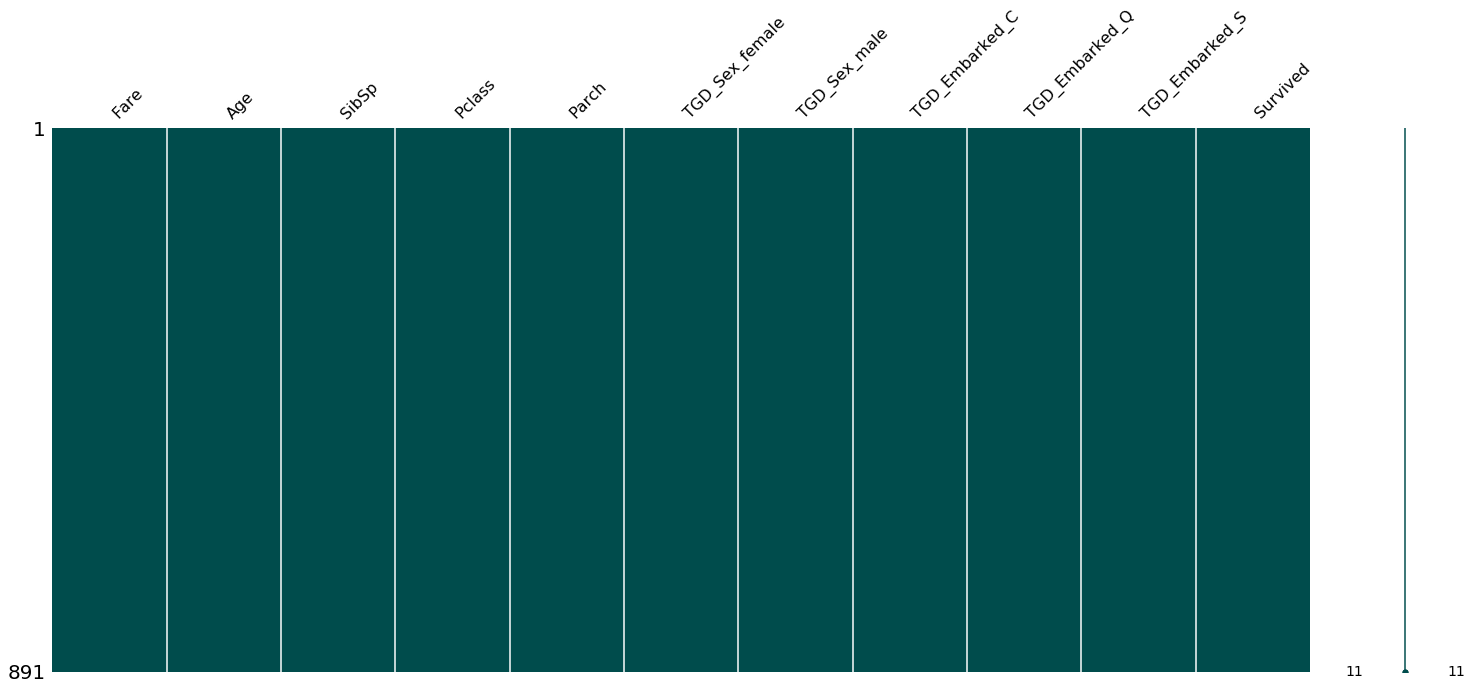

In [10]:
# Verificação dos missings
TuringMissingPlot(df_dp_09)

### Aplicando Método não supervisionado para seleção de variáveis (Variância)

In [11]:
from IPython.display import display, Math, Latex
display(Math(r'{\sigma}^2 = \frac{1}{N}\sum_{i=1}^{N} (y_{i}-\mu)^2'))

<IPython.core.display.Math object>

In [12]:
df_var_sel = TuringUnsupVariableSelection(df_dp_09,threshold=0.8)
df_var_sel.head()

,Fare,Age,SibSp,Pclass,Parch
0,-0.502445,-0.592481,0.432793,0.827377,-0.473674
1,0.786845,0.638789,0.432793,-1.566107,-0.473674
2,-0.488854,-0.284663,-0.474545,0.827377,-0.473674
3,0.420730,0.407926,0.432793,-1.566107,-0.473674
4,-0.486337,0.407926,-0.474545,0.827377,-0.473674


### Verificação da quantidade ótima de clusters - Método Silhueta

In [13]:
qtd_clusters, vec_silhueta, vec_clusters = TuringKmeansSilhouete(df_var_sel,20)
qtd_clusters

19

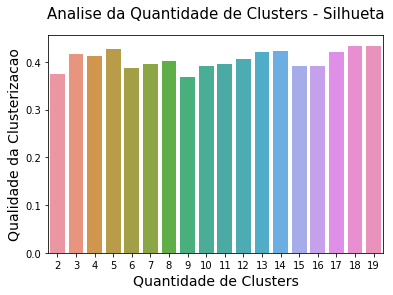

In [14]:
TuringKmeansPlotSilhouete(vec_clusters,vec_silhueta)

### Verificação da Quantidade de Clusters - Método WCSS (within-cluster sums of squares)

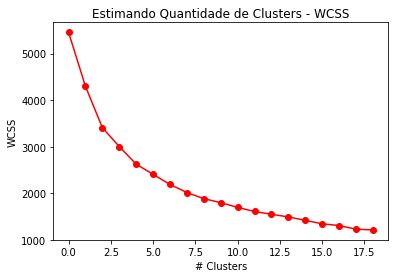

In [15]:
a,b=TuringKmeansPlotElbow(df_dp_09,1,20,plot_wcss='yes')

In [16]:
dff,kmmodel = TuringKmeansClustering(df_var_sel,n_clusters = 3,max_iter = 300,n_jobs=10)

In [17]:
# Implantando modelo ------------------------------------------------------------
TuringDeployModelToS3(S3resource,nm_bucket,id_modelo,id_projeto,'kmeans',kmmodel)

'Turing Success Deployment'

In [18]:
dff.head(10)

,Fare,Age,SibSp,Pclass,Parch,cluster
0,-0.502445,-0.592481,0.432793,0.827377,-0.473674,2
1,0.786845,0.638789,0.432793,-1.566107,-0.473674,1
2,-0.488854,-0.284663,-0.474545,0.827377,-0.473674,2
3,0.420730,0.407926,0.432793,-1.566107,-0.473674,1
4,-0.486337,0.407926,-0.474545,0.827377,-0.473674,2
5,-0.478116,0.000000,-0.474545,0.827377,-0.473674,2
6,0.395814,1.870059,-0.474545,-1.566107,-0.473674,1
7,-0.224083,-2.131568,2.247470,0.827377,0.767630,0
8,-0.424256,-0.207709,-0.474545,0.827377,2.008933,2
9,-0.042956,-1.208115,0.432793,-0.369365,-0.473674,2


### Vamos observar a distribuição dos pares de variáveis (Pairplot)

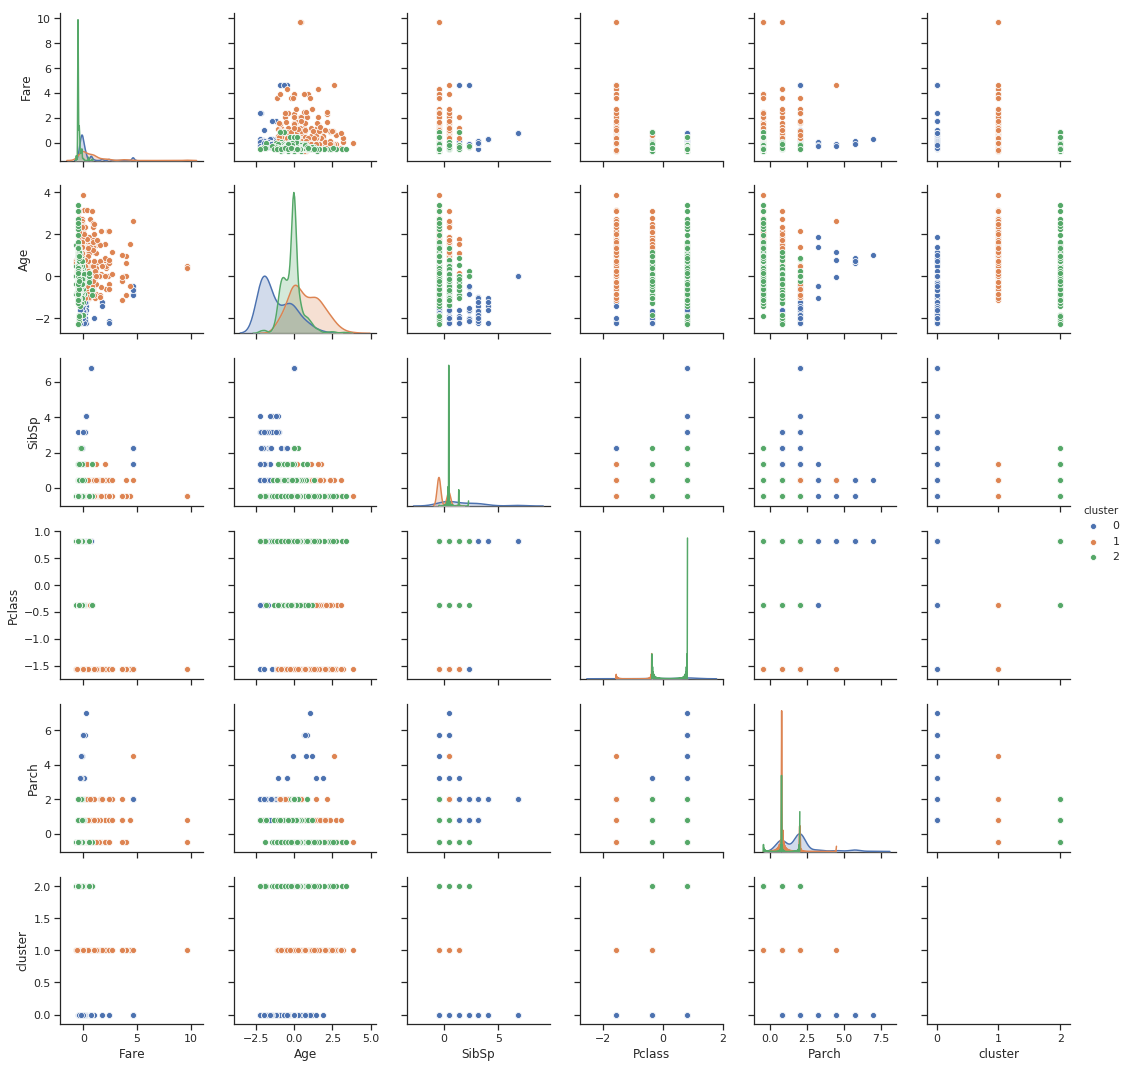

In [19]:
TuringClusteringPairPlot(dff,'cluster',dff.columns)    

In [20]:
df_impkm = TuringKmeansVariableImportance(dff)
df_impkm

,Variaveis,PearsonCorr,Importancia
5,cluster,1.000000,1.000000
4,Parch,-0.628319,0.628319
2,SibSp,-0.521538,0.521538
3,Pclass,0.422458,0.422458
0,Fare,-0.396180,0.396180
1,Age,0.095252,0.095252


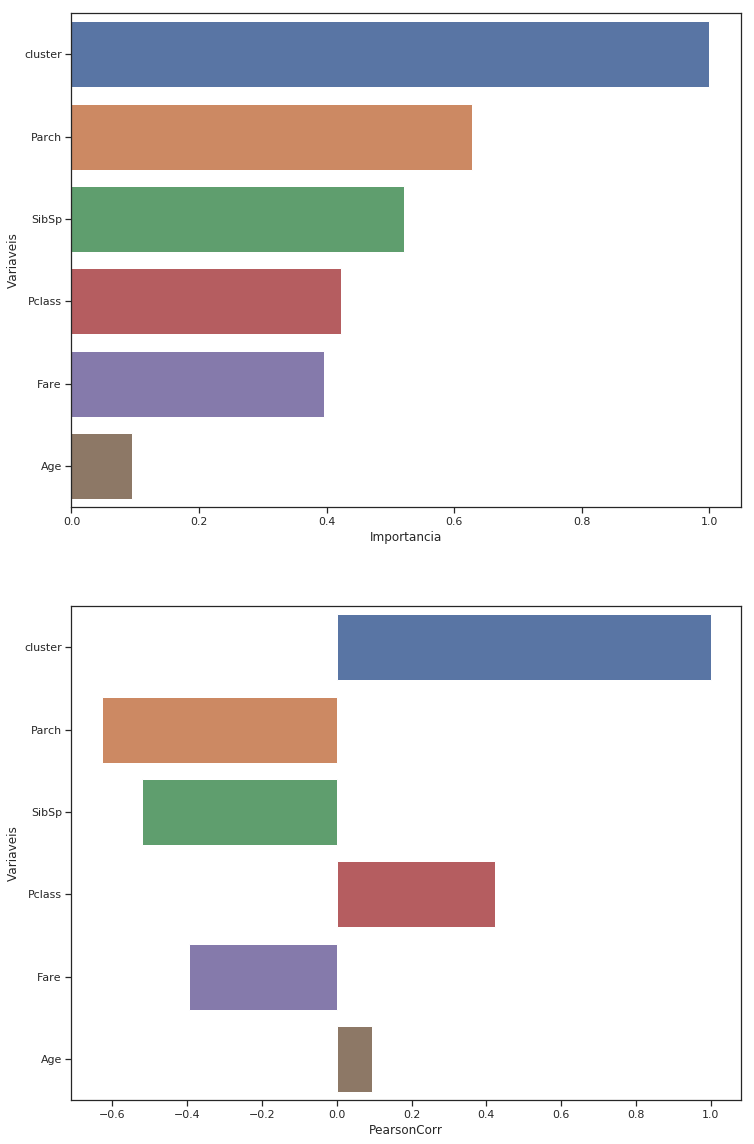

In [21]:
TuringKmeansVariableImportancePlot(df_impkm,fig_x = 12, fig_y = 20)

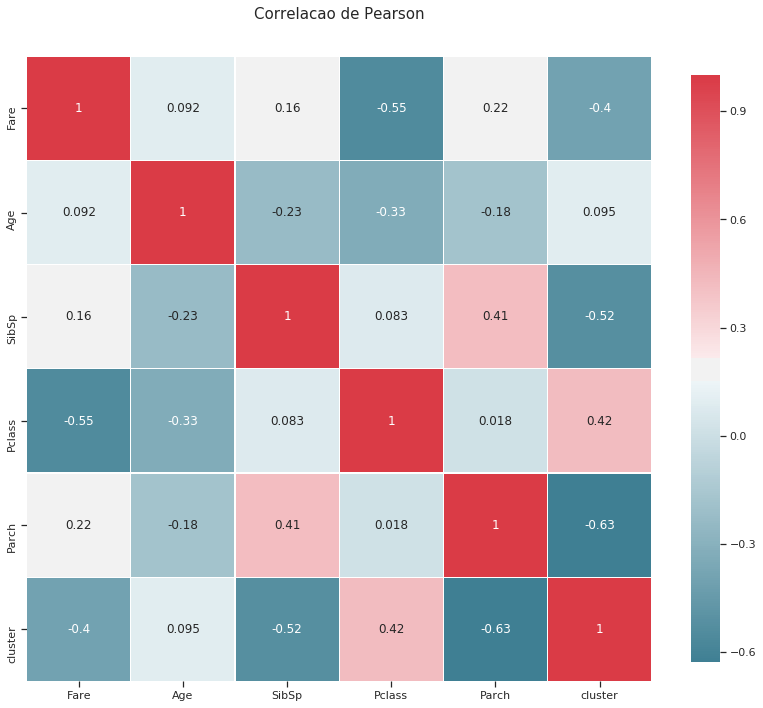

In [22]:
# Vamos analisar a correlaçao entre as variaveis e o cluster
TuringPearsonCorr(dff)

### Inferindo perfil dos clientes atraves da Clusterização

#### Perfil 1

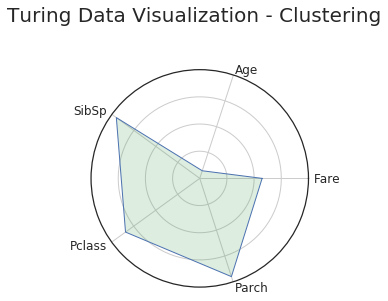

In [23]:
TuringPlotRadarClustering(dff,'cluster', 1)

### Perfil dos indivíduos neste cluster 
* Pessoas mais jovens 
* Tem muitos parentes no navio
* Classe mais baixa
* Pagou por um ticket devalor médio/baixo


#### Perfil 2

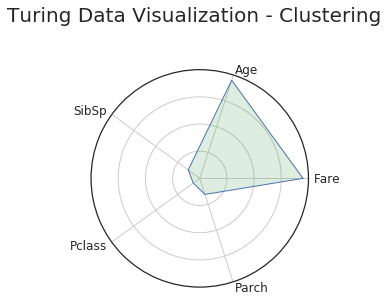

In [24]:
TuringPlotRadarClustering(dff,'cluster', 2)

### Perfil dos indivíduos neste cluster 
* Pessoas mais velhas 
* Não tem parentes no navio
* Classe Alta
* Pagou por um ticket devalor alto


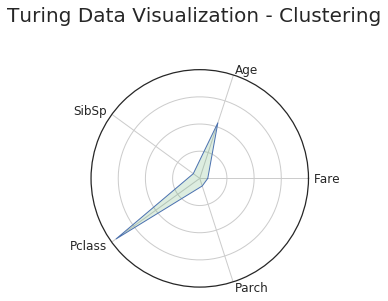

In [25]:
TuringPlotRadarClustering(dff,'cluster', 3)

In [29]:
TuringVolumeCateg(dff[['SibSp','Pclass','Parch','cluster']],dff[['SibSp','Pclass','Parch','cluster']].columns)

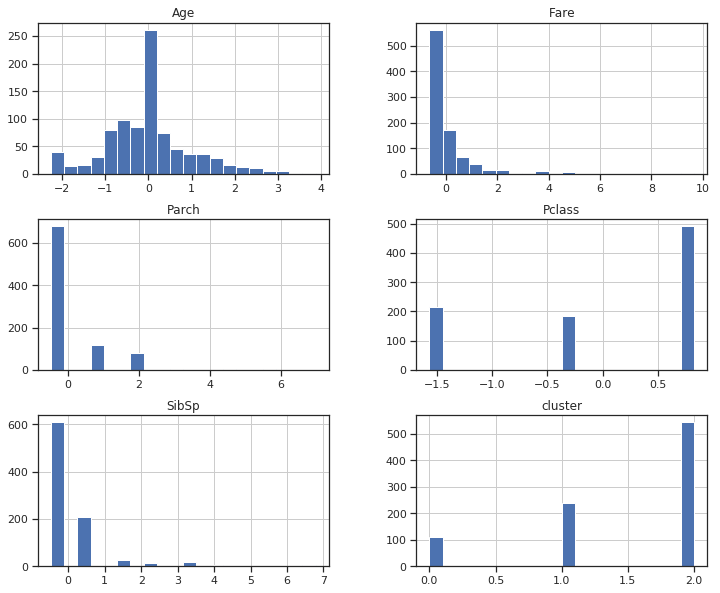

In [30]:
TuringHistogram(dff) 

#### Salvando tabela com marcação de clusters

In [33]:
s3_path_valida = 'turing-bkt-treinamentos/Projetos/SCORED_TABLES/'
nm_s3_file = 'CLUS01_TITANIC_TRAIN.csv'
TuringWriteS3CSVFile(dff,s3_path_valida,nm_s3_file,S3fs,delimiter=',')

'Arquivo Salvo Com Sucesso'